<a href="https://colab.research.google.com/github/660510745/229352---Statistical-Learning-for-Data-Science-2/blob/main/Lab09_Neural_Networks_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [26]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [27]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [28]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [29]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [30]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [31]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [32]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

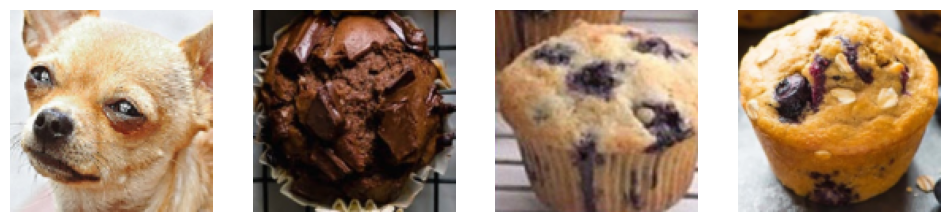

tensor([0, 1, 1, 1])


In [33]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

### 3. Initialize training components

In [34]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Flatten the input image (3 channels, 128x128 pixels) into a single vector
        self.flatten = nn.Flatten()
        # A single linear layer mapping the flattened input to 2 output logits (one for each class)
        self.linear = nn.Linear(3 * 128 * 128, 2)

    def forward(self, x):
        # Pass the input through the flatten layer
        x = self.flatten(x)
        # Pass the flattened input through the linear layer to get logits
        logits = self.linear(x)
        return logits

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [35]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [36]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [37]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [38]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [48]:
for X, y in train_loader:
    print(f"Shape of X (features): {X.shape}")
    print(f"Shape of y (labels): {y.shape}")
    break

Shape of X (features): torch.Size([10, 3, 128, 128])
Shape of y (labels): torch.Size([10])


#### Make a prediction on the minibatch (Forward pass)

In [50]:
y_hat = model(X)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [40]:
# Compute the loss


In [51]:
loss = criterion(y_hat, y)

#### Calculate the gradient (Backward pass)

In [52]:
loss.backward() # Computes gradients

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [53]:
optimizer.step()  # Update the weights using the gradient descent rule
model.zero_grad() # Zero the gradients after updating

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [54]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([0.0127, 0.0169, 0.0164, 0.0166, 0.0183, 0.0162, 0.0177, 0.0194, 0.0135,
        0.0066, 0.0096, 0.0294, 0.0266, 0.0199, 0.0166, 0.0180, 0.0077, 0.0153,
        0.0122, 0.0154, 0.0114, 0.0365, 0.0148, 0.0207]) tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 0.])


In [55]:
print(train_losses)
print(val_losses)

[6.907755374908447, 6.976834297180176, 25.168346405029297, 35.22727584838867, 37.17725372314453, 14.281525611877441, 57.22270965576172, 46.339752197265625, 40.286537170410156, 86.29729461669922, 1.585470999998506e-05, 46.547569274902344, 129.7193603515625, 126.15409088134766, 91.8180160522461, 139.78079223632812, 83.11055755615234, 99.11367797851562, 103.239013671875, 17.867290496826172, 40.049686431884766, 132.62144470214844, 300.8730773925781, 231.06863403320312, 122.00806427001953, 182.3450164794922, 231.21710205078125, 62.90074920654297, 157.20230102539062, 48.24755859375, 68.5924301147461, 178.2508544921875, 90.09944152832031, 110.96444702148438, 230.722900390625, 19.452648162841797, 158.15016174316406, 326.5557861328125, 158.2501220703125, 2.834226131439209, 160.43115234375, 78.04779815673828, 211.99395751953125, 139.35000610351562, 180.87054443359375, 133.31729125976562, 194.93649291992188, 59.311553955078125, 395.7105712890625, 46.41270446777344, 247.0413360595703, 289.39733886

#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

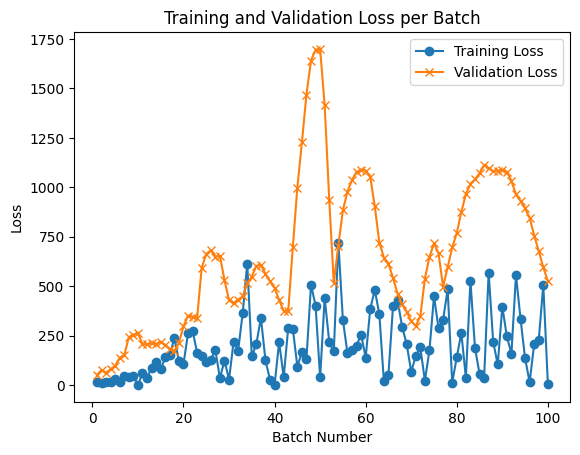

In [56]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [57]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Flatten รูป
        self.flatten = nn.Flatten()

        # Hidden layers (3 ชั้น)
        self.fc1 = nn.Linear(3 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        # Output layer (2 classes)
        self.out = nn.Linear(128, 2)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))

        x = self.out(x)

        return x

In [58]:
model = DeepNeuralNetwork()

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3   # เปลี่ยนเป็น 1e-2, 1e-4, 1e-5 ได้
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [59]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # Train
    model.train()
    running_loss = 0.0

    for X, y in train_loader:

        optimizer.zero_grad()

        y_hat = model(X)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X, y in val_loader:

            y_hat = model(X)
            loss = criterion(y_hat, y)

            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")


Epoch 1/20
Train Loss: 0.7047
Val Loss: 0.7044
Epoch 2/20
Train Loss: 0.6991
Val Loss: 0.7029
Epoch 3/20
Train Loss: 0.6967
Val Loss: 0.7016
Epoch 4/20
Train Loss: 0.6901
Val Loss: 0.6998
Epoch 5/20
Train Loss: 0.6875
Val Loss: 0.6984
Epoch 6/20
Train Loss: 0.6846
Val Loss: 0.6969
Epoch 7/20
Train Loss: 0.6800
Val Loss: 0.6951
Epoch 8/20
Train Loss: 0.6779
Val Loss: 0.6930
Epoch 9/20
Train Loss: 0.6742
Val Loss: 0.6902
Epoch 10/20
Train Loss: 0.6693
Val Loss: 0.6880
Epoch 11/20
Train Loss: 0.6664
Val Loss: 0.6854
Epoch 12/20
Train Loss: 0.6621
Val Loss: 0.6840
Epoch 13/20
Train Loss: 0.6575
Val Loss: 0.6816
Epoch 14/20
Train Loss: 0.6536
Val Loss: 0.6790
Epoch 15/20
Train Loss: 0.6482
Val Loss: 0.6768
Epoch 16/20
Train Loss: 0.6447
Val Loss: 0.6748
Epoch 17/20
Train Loss: 0.6416
Val Loss: 0.6722
Epoch 18/20
Train Loss: 0.6408
Val Loss: 0.6707
Epoch 19/20
Train Loss: 0.6296
Val Loss: 0.6686
Epoch 20/20
Train Loss: 0.6229
Val Loss: 0.6639


In [60]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  correct = (y_hat == y).sum().item()
  accuracy = correct / y.size(0)

print("Test Accuracy:", accuracy)



Test Accuracy: 0.5666666666666667


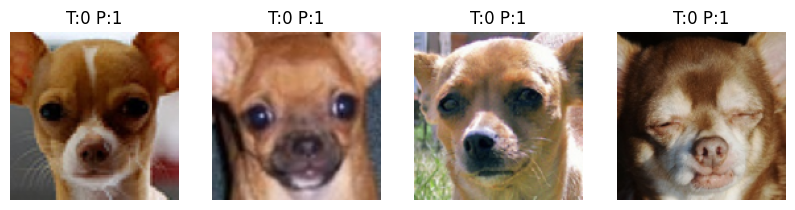

In [61]:
model.eval()

wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for X, y in test_loader:

        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)

        wrong = preds != y

        for i in range(len(y)):
            if wrong[i] and len(wrong_images) < 4:
                wrong_images.append(X[i])
                wrong_labels.append(y[i])
                wrong_preds.append(preds[i])

# Plot
plt.figure(figsize=(10,5))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(wrong_images[i].permute(1,2,0))
    plt.title(f"T:{wrong_labels[i]} P:{wrong_preds[i]}")
    plt.axis("off")

plt.show()
